       date  hours  nclicks
0  20130915      6    60277
1  20130916      3     5786
2  20130917      0        0
3  20130918      0        0
4  20130919      0        0


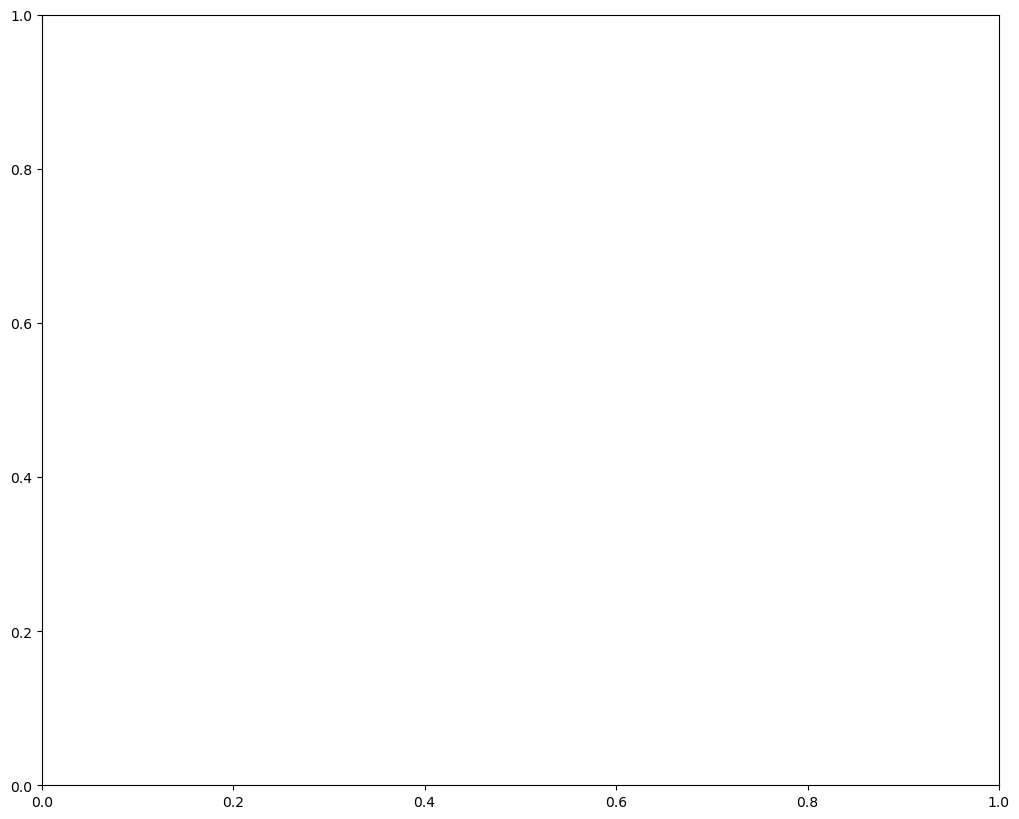

In [1]:
#Load libraries and modify all user params:

import requests
from datetime import datetime, timedelta
from PIL import Image
from io import BytesIO
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np

#Define function for date conversion between matlab and python:

from datetime import datetime, timedelta

def matlab_datenum_to_datetime(matlab_datenum):
    python_date = datetime.fromordinal(int(matlab_datenum)) + timedelta(days=int(matlab_datenum%1)) - timedelta(days=366)
    return python_date

# Load detection hours data from a CSV file
detection_data_path = 'C:/Users/HARP/animations/CANARC_BS_All_Mm_DayTots.csv'
detection_data = pd.read_csv(detection_data_path)

#Since first column is in matlab datenums, let's handle that, and also make sure that it matches the dates on the image filenames:

detection_data['date'] = detection_data['date'].apply(matlab_datenum_to_datetime)
detection_data['date'] = detection_data['date'].dt.strftime('%Y%m%d')


# Define the start and end dates of your period range
start_date = datetime(2014, 9, 9)
end_date = datetime(2014, 11, 30)  

# URL for your database
#url_template = 'https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/{year}/{month}/Resolute/asi-AMSR2-n3125-{date}-v5_visual.png' #For png version (includes grids, date, legend)
url_template = 'https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/{year}/{month}/{area}/asi-AMSR2-n3125-{date}-v5.tif' #For tiff files (just geospatial data)

# Define the recording location (x, y) in image coordinates. Choose also the area, since this will dictate how files will be named and saved.
#Later on I will modify code so that  the rest of characteristics also get altered (bubble size..etc.).

#area = 'Arctic3125'
area = 'Resolute'
#area = 'NorthWestPassage'

recording_location = (190, 215)  # Look more into this, eyeballing for now.These match RESOLUTE Scale.
#recording_location = (430, 1070)  #Approx location at NORTHWESTPASSAGE Scale

# Prepare the figure for plotting

#fig, ax = plt.subplots(figsize=(20, 16), dpi=100) #For TIF files ARCTIC
#fig, ax = plt.subplots(figsize=(113, 166), dpi=100) #For png
fig, ax = plt.subplots(figsize=(10, 8), dpi=100) #For TIF files RESOLUTE
plt.tight_layout(pad=0)

images = [] #This creates the string to store them

# Display first few rows of detections, to doublecheck that everything looks good:

print(detection_data.head())



In [2]:
#This first section is just to create somo color palettes for the map:

from palettable.colorbrewer.diverging import BrBG_11
from matplotlib.colors import LinearSegmentedColormap

#colors = ["steelblue", "powderblue", "gainsboro", "white", "lightgrey", "darkgrey"] #For soft arctic colors.
colors =  ["steelblue", "powderblue", "gainsboro", "white", "lightgrey", "slategrey"]

 # Ocean to Ice to Land # Ocean to Ice to Land
n_bins = [0, 0.3, 0.5, 0.7, 0.85, 1]  # Adjust these points to fit the distribution of your data
cmap_name = "custom"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, list(zip(n_bins, colors)))


# Loop over each date in the range
for current_date in pd.date_range(start_date, end_date):
    print("Processing date:", current_date)
    year = current_date.strftime('%Y')
    month = current_date.strftime('%b').lower()  # Use '%b' for abbreviated month name
    day = current_date.strftime('%Y%m%d')  # Use '%d' for day as two digits

    # Get the detection hours for the current date
    detection_hours = detection_data.loc[detection_data['date'] == day, 'hours'].values
    if detection_hours:
        detection_hours = detection_hours[0]
        bubble_size = detection_hours * 40 #For RESOLUTE Scale
        #bubble_size = detection_hours * 20 #For ARCTIC Scale
    else:
        detection_hours = 0
        bubble_size = 0  # Minimum size if no detections

    print("Detection hours for", current_date, ":", detection_hours)

    # Generate the URL for the current date's image
    url = url_template.format(year=year, month=month, date=day, area=area)
    print(f"Fetching from URL: {url}")

    # Attempt to download the image
    response = requests.get(url)
    if response.status_code == 200:
        # Open the image directly without converting it
        img = Image.open(BytesIO(response.content))

        # Convert image to a numpy array suitable for animation
        img_array = np.array(img)
        
        # Clear the axis and create a new image display
        ax.clear()
        ax.imshow(img_array, cmap=custom_cmap) # If you want to change the color palette, add cmap = 'viridis' / 'gray', whatever. This goes inside parenthesis.
        
        # Display the image in matplotlib with annotations
        ax.scatter(recording_location[0], recording_location[1], s=bubble_size, color='lime', alpha=0.5)  # Red bubble
        ax.text(0.05, 0.95, f"{day} ({detection_hours} hrs)", color='black', fontsize=24, transform=ax.transAxes, verticalalignment='top') 
        ax.axis('off')

        # Draw the canvas with the annotations and convert to an image
        fig.canvas.draw()
        # Convert the canvas buffer to an RGBA image
        image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        # Reshape the image to the correct dimensions
        image_from_plot = image_from_plot.reshape((int(fig.canvas.get_width_height()[1]), int(fig.canvas.get_width_height()[0]), 4))
        
        # Save the current image for verification
        Image.fromarray(image_from_plot[:, :, :3], 'RGB').save(f'E:/CANARC_All/animations/CANARC_BS/{year}/{area}/{area}_{day}.png') 
       
        
        # Append the processed frame to the list
        images.append(image_from_plot)
    else:
        print(f"Failed to download image for {day} from {url}")

# Close the plot figure
plt.close(fig)


Processing date: 2014-09-09 00:00:00
Detection hours for 2014-09-09 00:00:00 : 0
Fetching from URL: https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/2014/sep/Resolute/asi-AMSR2-n3125-20140909-v5.tif
Processing date: 2014-09-10 00:00:00
Detection hours for 2014-09-10 00:00:00 : 1
Fetching from URL: https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/2014/sep/Resolute/asi-AMSR2-n3125-20140910-v5.tif
Processing date: 2014-09-11 00:00:00
Detection hours for 2014-09-11 00:00:00 : 0
Fetching from URL: https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/2014/sep/Resolute/asi-AMSR2-n3125-20140911-v5.tif
Processing date: 2014-09-12 00:00:00
Detection hours for 2014-09-12 00:00:00 : 0
Fetching from URL: https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/2014/sep/Resolute/asi-AMSR2-n3125-20140912-v5.tif
Processing date: 2014-09-13 00:00:00
Detection hours for 2014-09-13 00:00:00 : 1
Fetching from URL: https://data.seaice.uni-bremen.de/amsr2/asi_

In [3]:
import os

def crop_map_area(image_path):
    with Image.open(image_path) as img:
        # Convert the image to RGB if it's not
        img = img.convert('RGB')
        img_array = np.array(img)
        
        # Assuming map areas are not pure white
        non_white_pixels = np.where(np.all(img_array != [255, 255, 255], axis=-1))
        upper_left = (np.min(non_white_pixels[1]), np.min(non_white_pixels[0]))
        lower_right = (np.max(non_white_pixels[1]), np.max(non_white_pixels[0]))
        
        # Crop the image to the bounding box of non-white areas
        cropped_img = img.crop((upper_left[0], upper_left[1], lower_right[0], lower_right[1]))
        return np.array(cropped_img)

# Path to your images
images_path = f'E:/CANARC_All/animations/CANARC_BS/{year}/{area}'
#images_path = f'E:/CANARC_All/animations/CANARC_BS/2018/Resolute'
image_files = [os.path.join(images_path, img) for img in sorted(os.listdir(images_path)) if img.endswith('.png')]

# List to hold cropped images
cropped_images = []
for file in image_files:
    # Crop the map area of each image
    cropped_img = crop_map_area(file)
    cropped_images.append(cropped_img)

# Save as GIF, using the cropped images
imageio.mimsave(f'E:/CANARC_All/animations/CANARC_BS/{year}/{area}_{year}_4fps.gif', cropped_images, fps=4)
imageio.mimsave(f'E:/CANARC_All/animations/CANARC_BS/{year}/{area}_{year}_2fps.gif', cropped_images, fps=2)

print(f"Done processing files for {area} for {year}. Animation has been created and saved.")

Done processing files for Resolute for 2014. Animation has been created and saved.


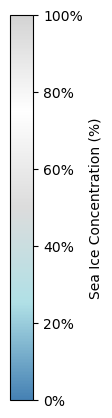

In [22]:
#Let's make the legend:

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colorbar import ColorbarBase

#Sea Ice scale:

# Adjusted colormap for sea ice concentration

colors = ["steelblue", "powderblue", "gainsboro", "white", "lightgrey"]
n_bins = [0, 0.25, 0.5, 0.75, 1]  # Adjust these points to fit the distribution of sea ice concentration
cmap_name = "custom_ice"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, list(zip(n_bins, colors)))

# Create a figure and a single subplot
#fig, ax = plt.subplots(figsize=(8, 0.5)) #If horizontal
fig, ax = plt.subplots(figsize=(0.3, 5)) #If vertical


# Normalize from 0% to 100%
norm = Normalize(vmin=0, vmax=100)

# Create the colorbar
cb = ColorbarBase(ax, cmap=custom_cmap, norm=norm, orientation='vertical')

# Set the colorbar labels
cb.set_label('Sea Ice Concentration (%)')
cb.set_ticks([0, 20, 40, 60, 80, 100])
cb.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

plt.savefig(f'E:/CANARC_All/animations/CANARC_BS/CANARC_BS_seaIce_colorbar_vertical.jpg', bbox_inches='tight',dpi=300)

plt.show()


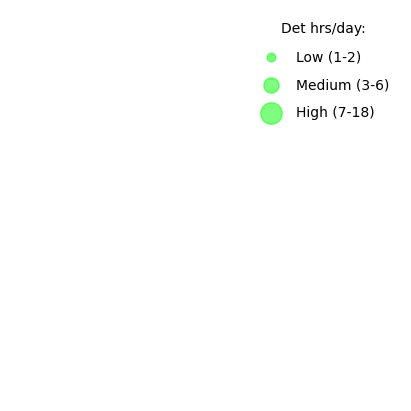

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colorbar import ColorbarBase

# Assume custom_cmap and norm are already defined from your colorbar for ice concentration

# Sample data for bubble sizes
bubble_sizes = [2*20, 6*20, 12*20]  # Example sizes in square points
bubble_labels = ['Low (1-2)', 'Medium (3-6)', 'High (7-18)']  # Corresponding labels for bubble sizes

fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)

# Creating a legend for bubble sizes
for size, label in zip(bubble_sizes, bubble_labels):
    ax.scatter([], [], s=size, c='lime', alpha=0.5, label=label)  # Adjust color if needed

ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Det hrs/day:')
ax.axis('off')


plt.savefig(f'E:/CANARC_All/animations/CANARC_BS/CANARC_BS_detHours_legend_vertical.png', bbox_inches='tight', dpi=400)

plt.show()
